In [29]:
pip install opencv-python scikit-learn matplotlib pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import cv2
import numpy as np
from tqdm import tqdm

DATASET_PATH = "/kaggle/input/image-retrivel/UCMerced_LandUse/Images"
IMAGE_SIZE = (128, 128)

images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

for class_name in class_names:
    class_folder = os.path.join(DATASET_PATH, class_name)
    for image_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        images.append(img)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape: {images[0].shape}")

Loaded 2100 images with shape: (128, 128, 3)


In [31]:
from skimage.feature import local_binary_pattern

def extract_features(image):
    # Color histogram
    chans = cv2.split(image)
    color_hist = np.concatenate([
        cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten()
        for ch in chans
    ])

    # Texture (LBP)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)

    return np.concatenate([color_hist, lbp_hist])

features = np.array([extract_features(img) for img in tqdm(images)])
print("✅ Features shape:", features.shape)


100%|██████████| 2100/2100 [00:07<00:00, 285.78it/s]

✅ Features shape: (2100, 105)


In [32]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


In [33]:
def evaluate_genetic(individual, features, labels):
    mask = np.array(individual) > 0.5
    if np.sum(mask) == 0:
        return 0.0,
    X_sel = features[:, mask]
    X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return acc,


In [34]:
def genetic_algorithm(features, labels, n_population=20, n_generations=20, cxpb=0.5, mutpb=0.2):
    from deap import base, creator, tools, algorithms

    n_features = features.shape[1]

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", lambda: random.randint(0, 1))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate_genetic, features=features, labels=labels)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=n_population)
    pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=n_generations, verbose=True)

    best_ind = tools.selBest(pop, k=1)[0]
    best_acc = evaluate_genetic(best_ind, features, labels)[0]

    return np.array(best_ind), best_acc


In [35]:
best_solution, best_score = genetic_algorithm(features_scaled, labels_encoded)
selected_features = features_scaled[:, best_solution > 0.5]

print(f"Final Accuracy (Best GA Individual): {best_score:.4f}")
print(f"Selected {np.sum(best_solution > 0.5)} features out of {features_scaled.shape[1]}")


gen	nevals
0  	20    
1  	12    
2  	10    
3  	8     
4  	12    
5  	10    
6  	14    
7  	9     
8  	11    
9  	13    
10 	14    
11 	5     
12 	12    
13 	11    
14 	10    
15 	11    
16 	13    
17 	11    
18 	9     
19 	14    
20 	15    
Final Accuracy (Best GA Individual): 0.6127
Selected 59 features out of 105


In [36]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels_encoded, test_size=0.3)
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


                   precision    recall  f1-score   support

     agricultural       0.89      0.76      0.82        33
         airplane       0.48      0.69      0.56        35
  baseballdiamond       0.68      0.52      0.59        29
            beach       0.97      0.72      0.82        39
        buildings       0.56      0.62      0.59        29
        chaparral       0.96      0.79      0.87        34
 denseresidential       0.44      0.56      0.49        25
           forest       0.81      0.76      0.79        34
          freeway       0.61      0.50      0.55        28
       golfcourse       0.70      0.81      0.75        32
           harbor       0.89      0.89      0.89        28
     intersection       0.46      0.72      0.56        29
mediumresidential       0.43      0.75      0.55        24
   mobilehomepark       0.77      0.85      0.81        27
         overpass       0.64      0.62      0.63        29
       parkinglot       0.54      0.48      0.51       

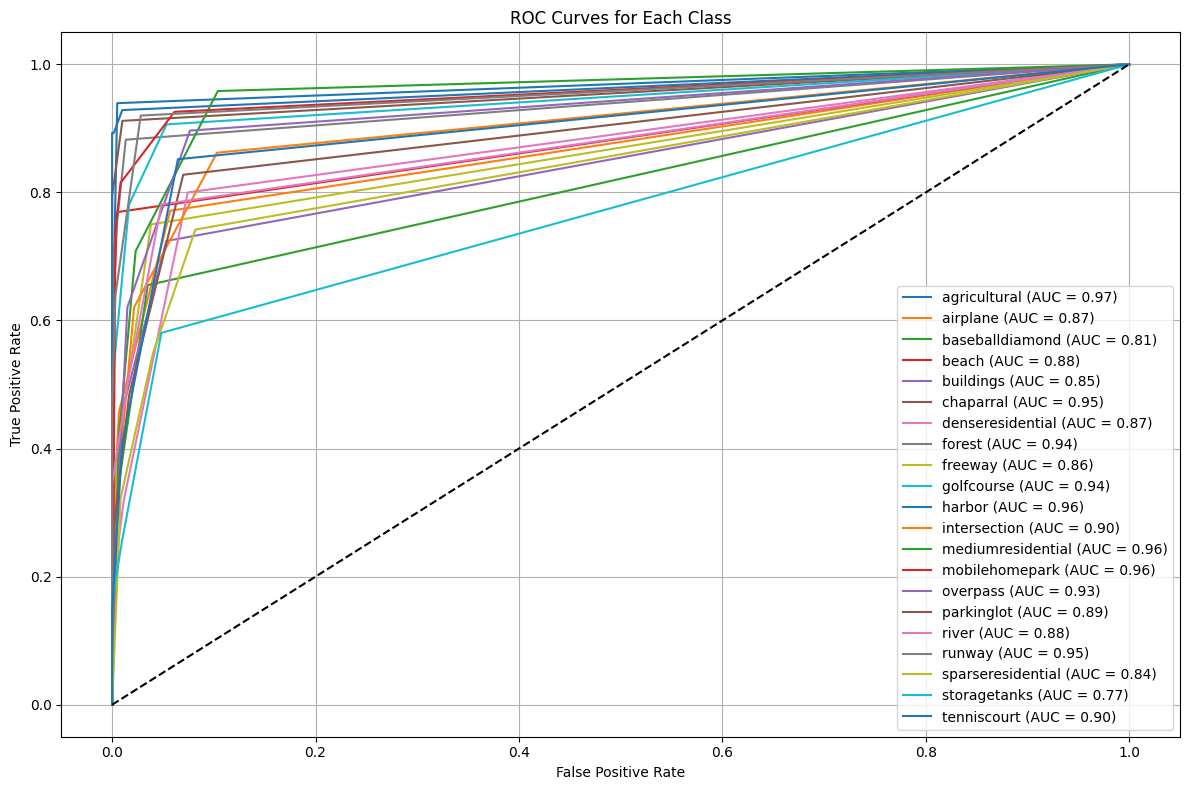

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels for multi-class AUC
y_test_bin = label_binarize(y_test, classes=np.unique(labels_encoded))
y_pred_prob = clf.predict_proba(X_test)

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each class
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


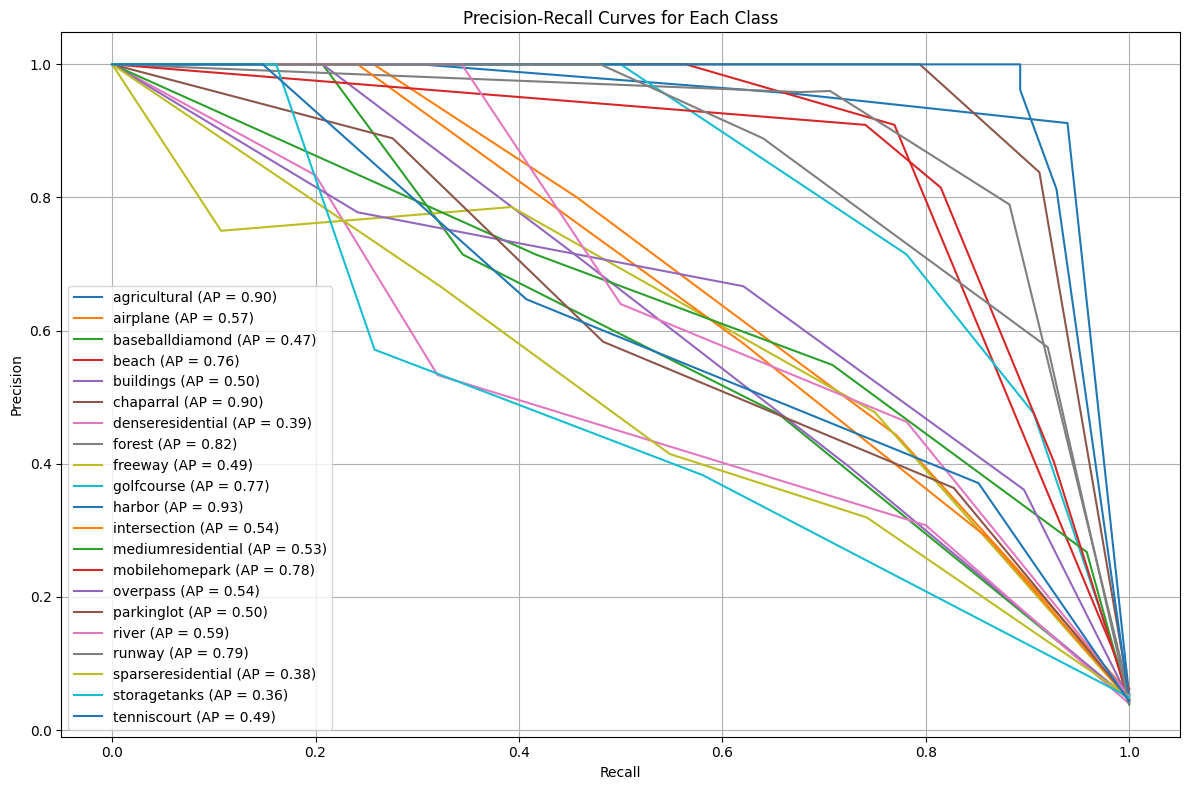

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{le.classes_[i]} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()


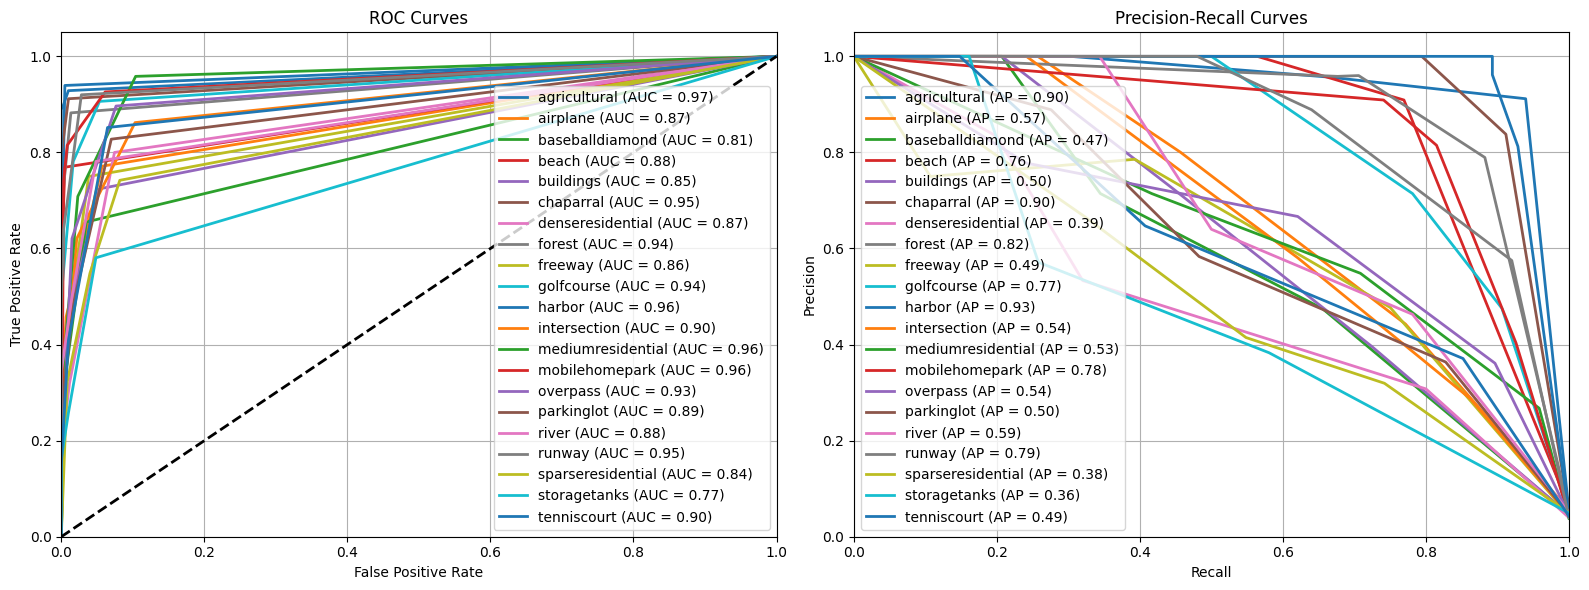

In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve Plot
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc="lower right")
axes[0].grid()

# Precision-Recall Curve Plot
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    axes[1].plot(recall, precision, lw=2, label=f'{le.classes_[i]} (AP = {ap:.2f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc="lower left")
axes[1].grid()

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

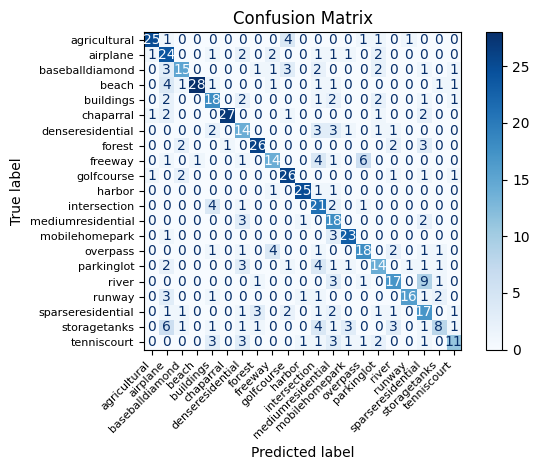

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Display full report
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

# Find class with highest accuracy (f1-score used as proxy)
sorted_f1 = report_df.iloc[:-3].sort_values(by="f1-score", ascending=False)  # Ignore 'accuracy', 'macro avg', 'weighted avg'

top_class = sorted_f1.head(1)
print("\n Class with highest F1-score:")
print(top_class)


                   precision    recall  f1-score     support
agricultural        0.892857  0.757576  0.819672   33.000000
airplane            0.480000  0.685714  0.564706   35.000000
baseballdiamond     0.681818  0.517241  0.588235   29.000000
beach               0.965517  0.717949  0.823529   39.000000
buildings           0.562500  0.620690  0.590164   29.000000
chaparral           0.964286  0.794118  0.870968   34.000000
denseresidential    0.437500  0.560000  0.491228   25.000000
forest              0.812500  0.764706  0.787879   34.000000
freeway             0.608696  0.500000  0.549020   28.000000
golfcourse          0.702703  0.812500  0.753623   32.000000
harbor              0.892857  0.892857  0.892857   28.000000
intersection        0.456522  0.724138  0.560000   29.000000
mediumresidential   0.428571  0.750000  0.545455   24.000000
mobilehomepark      0.766667  0.851852  0.807018   27.000000
overpass            0.642857  0.620690  0.631579   29.000000
parkinglot          0.53

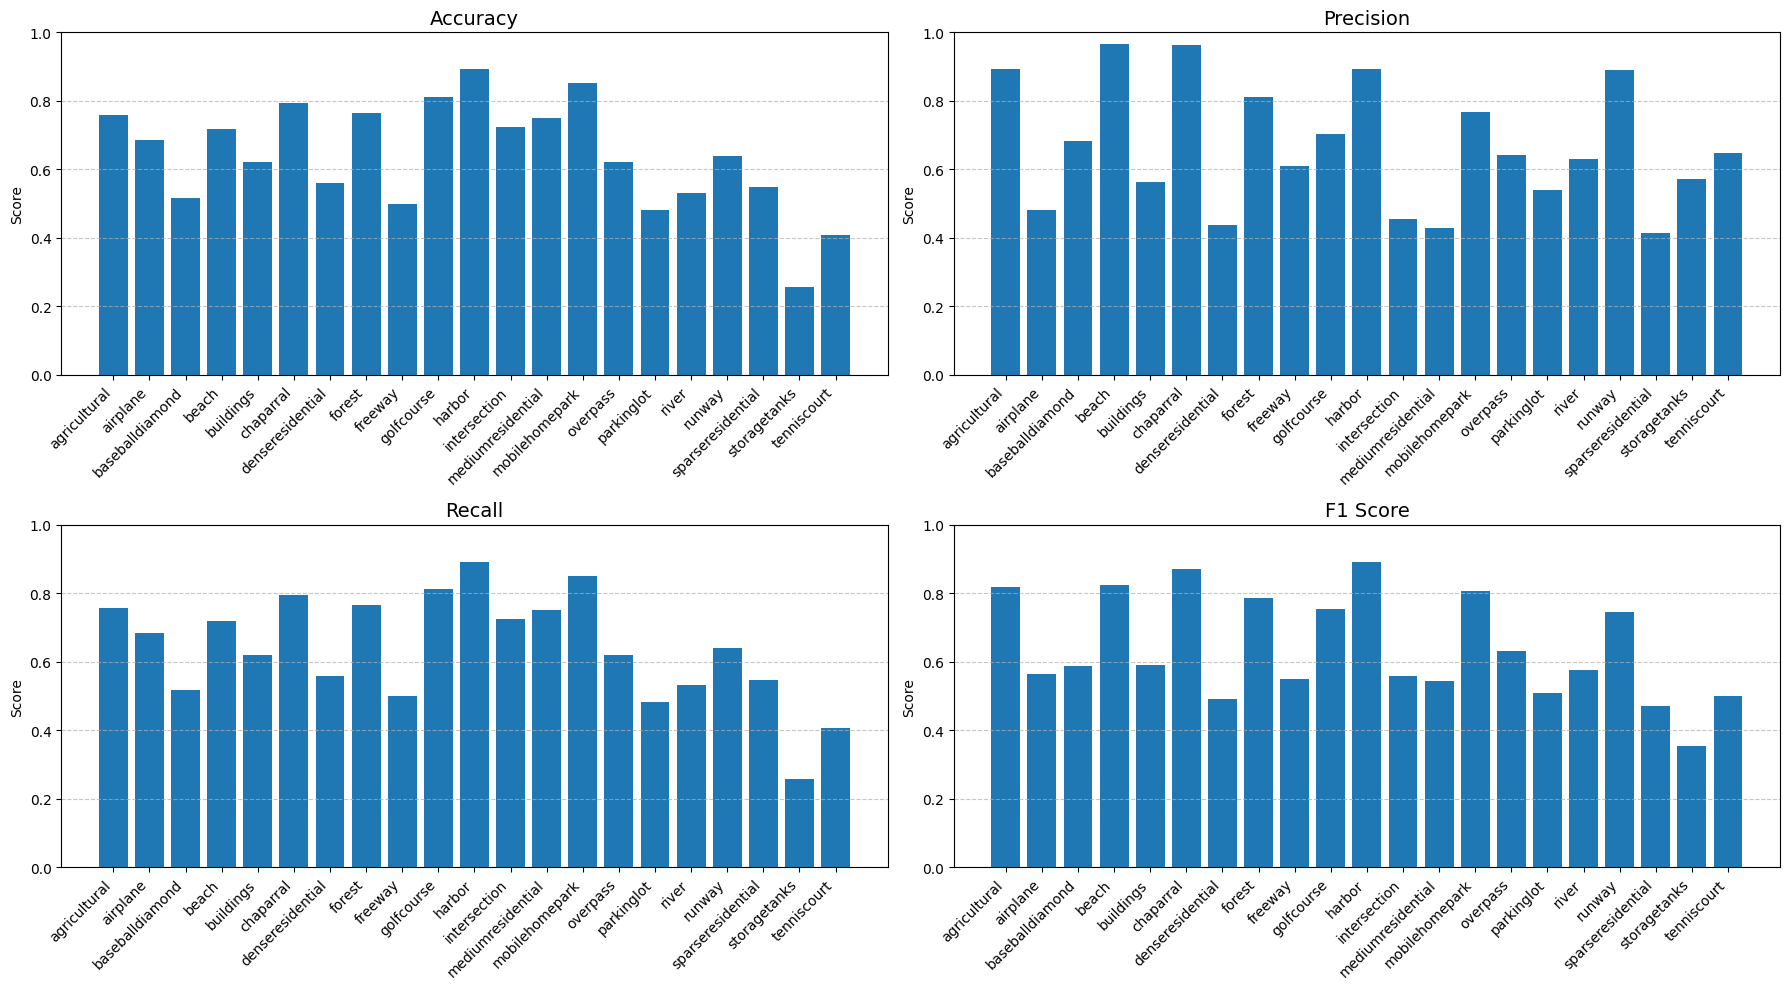

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Number of classes
num_classes = len(class_names)

# Calculate per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Accuracy per class = correct predictions / total samples of that class
accuracy = []
for i in range(num_classes):
    idx = y_test == i
    acc = np.sum(y_pred[idx] == i) / np.sum(idx)
    accuracy.append(acc)
accuracy = np.array(accuracy)

# Plotting
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i])
    ax.set_title(metric_names[i], fontsize=14)
    ax.set_ylabel("Score")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
